# Serving Runtime Remote Artifacts

In [1]:
import mlrun
import os

# Initialize the MLRun project object
project = mlrun.get_or_create_project('testing-notebooks',user_project=True,context='./')

# Required credentials :
# AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, GOOGLE_APPLICATION_CREDENTIALS, S3_BUCKET
AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID', None)
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY', None)
GOOGLE_APPLICATION_CREDENTIALS = os.environ.get('GOOGLE_APPLICATION_CREDENTIALS', None)
assert AWS_ACCESS_KEY_ID != None and AWS_SECRET_ACCESS_KEY != None and GOOGLE_APPLICATION_CREDENTIALS != None

secrets = {'AWS_ACCESS_KEY_ID': AWS_ACCESS_KEY_ID,
           'AWS_SECRET_ACCESS_KEY':AWS_SECRET_ACCESS_KEY,
           'GOOGLE_APPLICATION_CREDENTIALS': GOOGLE_APPLICATION_CREDENTIALS}

project.set_secrets(secrets=secrets, provider='kubernetes')

S3_BUCKET = os.environ.get('S3_BUCKET', 'testbucket-igz')

project.artifact_path = os.path.join('s3://', S3_BUCKET + '/')

> 2022-12-20 14:44:59,716 [info] loaded project testing-notebooks from MLRun DB


In [2]:
# Setting dummy serving function
project.set_function(mlrun.new_function(name='serving', kind='serving',image='mlrun/ml-models', command = []))
project.get_function('serving').spec.build.commands = ['pip install -U xgboost']
project.get_function('serving').set_envs(secrets)
# adding our remote source model
model_artifact = project.get_artifact('log-transactions-log_transactions_bst_model')
model_path = model_artifact.get_target_path() + model_artifact.model_file

project.get_function('serving').add_model(key = 'my_model',
                                          class_name = "mlrun.frameworks.xgboost.XGBoostModelServer",
                                          model_path = model_path)

# mounting
project.get_function('serving').apply(mlrun.auto_mount())
project.get_function('serving').apply(mlrun.platforms.mount_s3())

In [3]:
server = project.get_function('serving').to_mock_server()

> 2022-12-20 14:45:00,120 [warning] run command, file or code were not specified
> 2022-12-20 14:45:05,926 [info] model my_model was loaded
> 2022-12-20 14:45:05,927 [info] Loaded ['my_model']


In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X,y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

server.test(body={'inputs': X_test.tolist()[:3]})

{'id': '3f2646634abf45919acda5120c2e43c9',
 'model_name': 'my_model',
 'outputs': [2, 1, 0]}

In [5]:
project.deploy_function('serving')

> 2022-12-20 14:45:06,092 [info] Starting remote function deploy
2022-12-20 14:45:06  (info) Deploying function
2022-12-20 14:45:06  (info) Building
2022-12-20 14:45:06  (info) Staging files and preparing base images
2022-12-20 14:45:06  (info) Building processor image
2022-12-20 14:48:23  (info) Build complete
2022-12-20 14:48:46  (info) Function deploy complete
> 2022-12-20 14:48:46,693 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-testing-notebooks-dani-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['testing-notebooks-dani-serving-testing-notebooks-dani.default-tenant.app.dev6.lab.iguazeng.com/']}


DeployStatus(state=ready, outputs={'endpoint': 'http://testing-notebooks-dani-serving-testing-notebooks-dani.default-tenant.app.dev6.lab.iguazeng.com/', 'name': 'testing-notebooks-dani-serving'})

In [6]:
import time
time.sleep(5)
project.get_function('serving').invoke('/v2/models/my_model/infer', body={'inputs': X_test.tolist()[:3]})

> 2022-12-20 14:48:51,814 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-testing-notebooks-dani-serving.default-tenant.svc.cluster.local:8080/v2/models/my_model/infer'}


{'id': 'a903377a-3ad2-4fda-85df-2cb19fd287cd',
 'model_name': 'my_model',
 'outputs': [2, 1, 0]}

# Pipeline remote access

In [7]:
%%writefile workflow.py
import mlrun
from kfp import dsl


@dsl.pipeline(name="Mask Detection Pipeline")

def kfpipeline():
    # Get our project object:
    project = mlrun.get_current_project()
    
    project.get_function('log_transactions').apply(mlrun.platforms.mount_s3())
    project.get_function('log_transactions').apply(mlrun.auto_mount())
    run = project.run_function('log_transactions')
    
    model_artifact = project.get_artifact('log-transactions-log_transactions_bst_model')
    model_path = model_artifact.get_target_path() + model_artifact.model_file
    
    project.get_function('serving').add_model(key = 'my_model',
                                          class_name = "mlrun.frameworks.xgboost.XGBoostModelServer",
                                          model_path = model_path)
    
    project.deploy_function('serving').after(run)
    return

Writing workflow.py


In [8]:
# Register the workflow file:
workflow_name = "iris_workflow"
project.set_workflow(workflow_name, "workflow.py")

# Save the project:
project.save()

In [9]:
# Running with S3
# project.run(name=workflow_name,watch=True, local=False, artifact_path=project.artifact_path)
project.save()

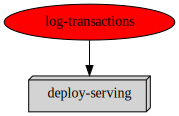

uid,start,state,name,parameters,results
...a67fd972,Dec 20 14:49:26,error,log-transactions,,


RuntimeError: Pipeline run status Failed

In [10]:
# Running with GCS
project.run(name=workflow_name,watch=True, local=False, artifact_path='gs' + project.artifact_path[2:])